##  Prediction experimental band gaps from Citrine database
This notebook is an example to show how to combined with other packages to predict compound's proprety.
We will use experimental band gaps fetch from Citrine's databases (https://citrination.com/)

### Step 1. fetch data from Citrine
Here we use [matminer](https://hackingmaterials.github.io/)'s `retrieve_Citrine` module to contract with Citrine's databases. You must install it first.

In [1]:
import matminer as mm
from matminer.data_retrieval.retrieve_Citrine import CitrineDataRetrieval
mm.__version__

'0.2.1'

In [2]:
from matminer.data_retrieval.retrieve_Citrine import CitrineDataRetrieval

# your Citrine API key
api_key = 'B8ovDFnrqxbf9UsSXKGRkAtt'
c = CitrineDataRetrieval(api_key)

json = c.get_api_data(property='band gap', data_type='experimental', max_results=1200)
df = c.get_dataframe(json, show_columns=['chemicalFormula', 'Band gap'] )

# filter out NaN
df = df.dropna(axis=0, how='all')
df = df.rename(columns={'Band gap': 'band_gap', 'chemicalFormula': 'formula'})
df.head()

  0%|          | 0/1200 [00:00<?, ?it/s]/usr/local/anaconda3/envs/xepy35/lib/python3.5/site-packages/matminer/data_retrieval/retrieve_Citrine.py:161: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  p_df.set_value(counter, prop["name"], parse_scalars(prop["scalars"]))
/usr/local/anaconda3/envs/xepy35/lib/python3.5/site-packages/matminer/data_retrieval/retrieve_Citrine.py:179: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  p_df.set_value(counter, prop["name"] + "-" + prop_key, prop[prop_key])
100%|██████████| 1200/1200 [00:19<00:00, 60.98it/s]


,formula,band_gap
system,,
1,Bi2Te3,0.153
2,Mg2Ge1,0.567
3,Co1Si1,0.045
4,Na1Br1,7.025
5,Ca2Sn1,0.9


Convert formula to composition. Also convert `band_gap` to `np.float`

> **warning**: formula H1p1 is illegal. drop it!

In [3]:
from matminer.utils.conversions import str_to_composition

# remove illegal data
mask = df['formula'].str.contains('p1')
df = df.loc[~mask, :]

df['band_gap'] = df['band_gap'].astype('float')
df["composition"] = str_to_composition(df["formula"])
df.head()

,formula,band_gap,composition
system,,,
1,Bi2Te3,0.153,"(Bi, Te)"
2,Mg2Ge1,0.567,"(Ge, Mg)"
3,Co1Si1,0.045,"(Co, Si)"
4,Na1Br1,7.025,"(Na, Br)"
5,Ca2Sn1,0.900,"(Sn, Ca)"


### Save it for next using.

In [4]:
from xenonpy.preprocess.datatools import DataSet

bg_expt = DataSet('bg_expt')  # use Saver
bg_expt.save(df)
bg_expt

"bg_expt" include:
"descriptor": 7
"X_train": 3
"lmd": 7
"band_gap_bc": 7
"y_train": 3
"unnamed": 5
"X_test": 3
"descriptor_scale": 7
"y_test": 3
"y_pred": 3

### Calculate elemental descriptors and draw a heatmap.

converting 1196 compounds


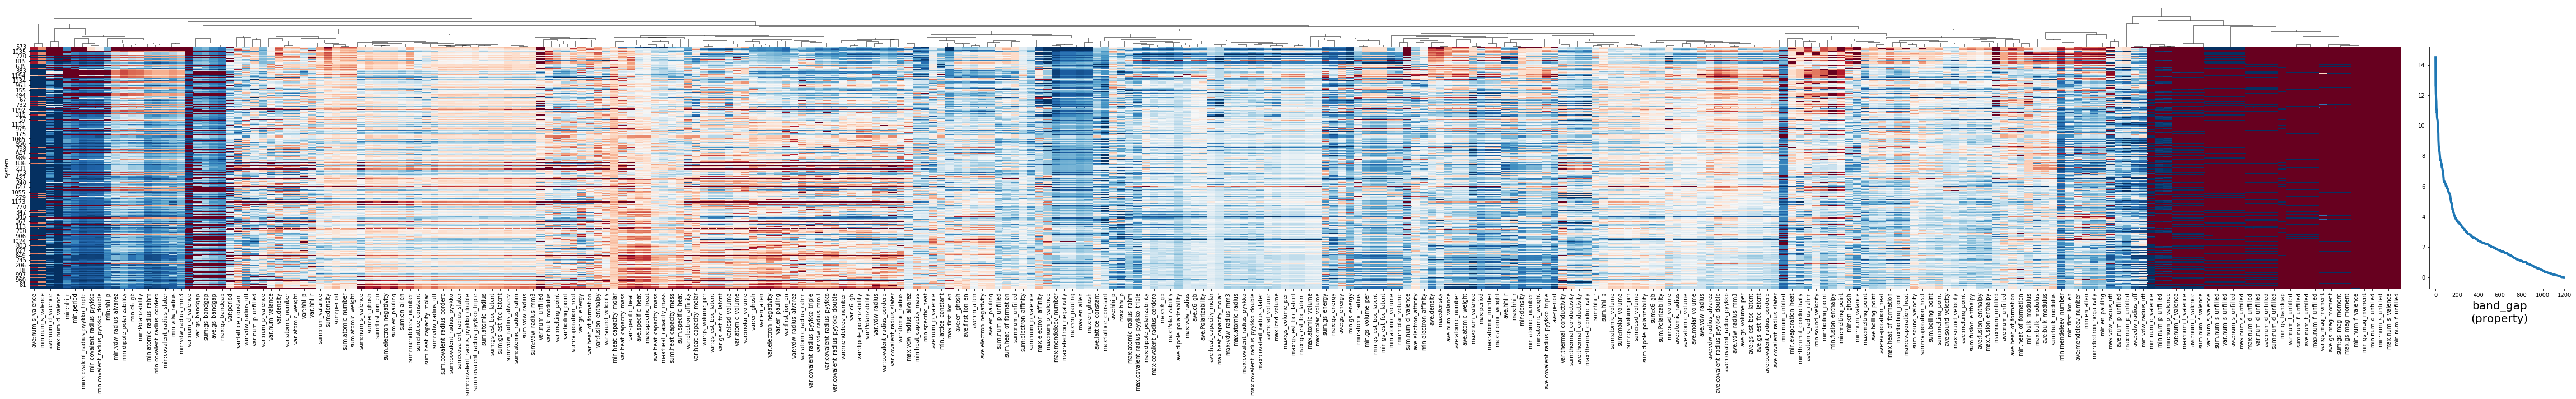

In [5]:
from xenonpy.descriptor import ElementDesc
from xenonpy.preprocess.datatools import Loader
from xenonpy.visualization import DescHeatmap

df = Loader().load('bg_expt').last()

desc = ElementDesc()  # use it with default paramters
df_sorted = df.sort_values(by='band_gap', ascending=False)

desc_bg = desc.fit_transform(df_sorted)
bg_expt.save(descriptor=desc_bg)

hmap = DescHeatmap(
    save=dict(fname='band_gap_desc_expt.png', dpi=150, bbox_inches='tight', transparent=False),
    method='complete', bc=True, figsize=(70, 10))

hmap.fit(desc_bg)
hmap.draw(df_sorted['band_gap'])

### Step 2. Try a random forest training

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox

import numpy as np

# box-cox transfer
bg_bc, lmd = boxcox(df_sorted['band_gap'])
bg_expt.save(band_gap_bc=bg_bc, lmd=lmd)

# standarded descriptor
scaler = StandardScaler()
desc_bg_scale = scaler.fit_transform(desc_bg)
bg_expt.save(descriptor_scale=desc_bg_scale)

# random forest
X_train, X_test, y_train, y_test = train_test_split(desc_bg_scale, bg_bc, test_size=0.2, random_state=0)
regr = RandomForestRegressor(max_depth=10, random_state=42, n_jobs=-1, verbose=0)
regr.fit(X_train, y_train)
y_true, y_pred = y_test, regr.predict(X_test)

print('R2 = ' + str(round(regr.score(X_train, y_train), 3)))
print('RMSE = %.3f' % np.sqrt(mean_squared_error(y_true, y_pred)))

R2 = 0.929
RMSE = 0.420


That's sound good! Let's plot it with seaborn for simple!

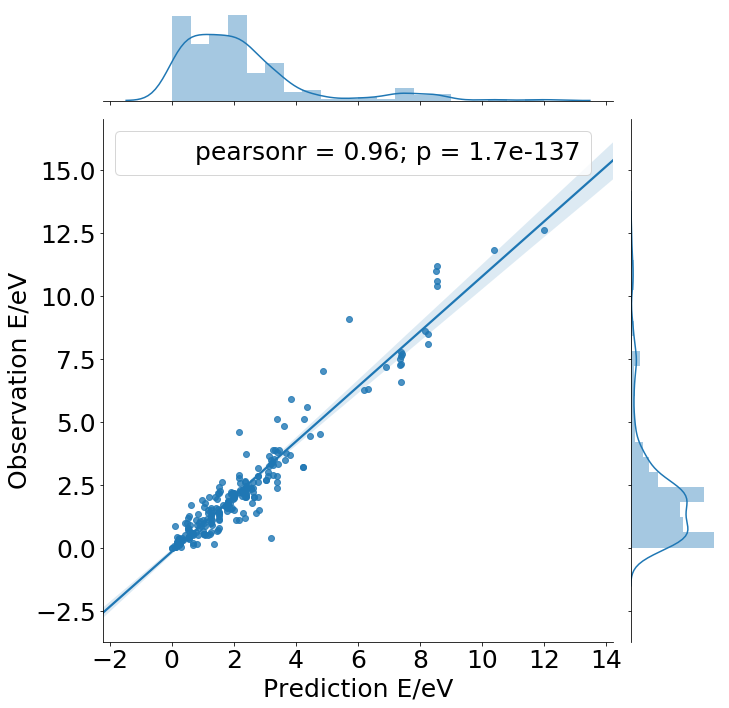

In [7]:
import seaborn as sb
import matplotlib as mpl
from scipy.special import inv_boxcox

y_train = inv_boxcox(y_train, lmd)
y_test = inv_boxcox(y_test, lmd)
y_pred = inv_boxcox(y_pred, lmd)

bg_expt.save(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, y_pred=y_pred)

with mpl.rc_context(rc={'font.size': 25}):
    ax = sb.jointplot(y_pred, y_test, kind="reg", size=10)
    ax.set_axis_labels('Prediction E/eV', 'Observation E/eV')

### Step 3. NN training with random model generator

In [8]:
from xenonpy.model.nn import Generator1d, ModelRunner
from xenonpy.model.nn import wrap
from math import ceil
from random import uniform

N_MAX = 20


gene = Generator1d(290, 1,
                   n_neuron=[ceil(uniform(0.8, 1.2) * 290) for n in range(5)],
                   drop_out=(0.1,),
                   batch_normalize=(None, wrap.L1.batch_norm())
                   )


def scheduler(_, paras):
    n_out = max(ceil(paras['n_out'] * uniform(0.5, 0.8)), N_MAX)
    return dict(paras, n_out=n_out)


ms = gene(4, n_models=1,
          replace=True,
          scheduler=scheduler
          )
next(ms)

Sequential(
  (0): Layer1d(
    (layer): Linear(in_features=290, out_features=249, bias=True)
    (batch_nor): BatchNorm1d(249, eps=1e-05, momentum=0.1, affine=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (1): Layer1d(
    (layer): Linear(in_features=249, out_features=161, bias=True)
    (batch_nor): BatchNorm1d(161, eps=1e-05, momentum=0.1, affine=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (2): Layer1d(
    (layer): Linear(in_features=161, out_features=101, bias=True)
    (batch_nor): BatchNorm1d(101, eps=1e-05, momentum=0.1, affine=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (3): Layer1d(
    (layer): Linear(in_features=101, out_features=79, bias=True)
    (batch_nor): BatchNorm1d(79, eps=1e-05, momentum=0.1, affine=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (4): Layer1d(
    (layer): Linear(in_features=79, out_features=1, bias=True)
  )
)

In [9]:
from xenonpy.model.nn.wrap import Init, Optim
import torch

X_train, X_test, y_train, y_test = train_test_split(desc_bg_scale, bg_bc, test_size=0.2, random_state=0)

with ModelRunner(3000, log_step=300, check_step=300, ctx='gpu') as runner:
    runner(m, init_weight=Init.uniform(), loss_func=torch.nn.MSELoss(), optim=Optim.adam(), lr=0.001)
    runner.fit(X_train, y_train)
    y_true, y_pred = runner.predict(X_test, y_test)

Runner environment:
Running dir: None
Epochs: 3000
Context: GPU
Check step: 300
Log step: 300

init weight -> Linear(in_features=290, out_features=249, bias=True)
init weight -> Linear(in_features=249, out_features=161, bias=True)
init weight -> Linear(in_features=161, out_features=101, bias=True)
init weight -> Linear(in_features=101, out_features=79, bias=True)
init weight -> Linear(in_features=79, out_features=1, bias=True)
=======start training=======
Model name: afa6b1f4b10b82c150b649c3f0f6a61a

at step[0/3000], Loss=2.0280


/Users/liuchang/projects/XenonPy/xenonpy/model/nn/runner.py:141: RuntimeWarning:

No cuda environment, use cpu fallback.



at step[300/3000], Loss=0.0938
at step[600/3000], Loss=0.0874
at step[900/3000], Loss=0.0797
at step[1200/3000], Loss=0.0821
at step[1500/3000], Loss=0.0840
at step[1800/3000], Loss=0.0776
at step[2100/3000], Loss=0.0786
at step[2400/3000], Loss=0.0778
at step[2700/3000], Loss=0.0784

Final loss=0.0785
=======over training=======



/Users/liuchang/projects/XenonPy/xenonpy/model/nn/runner.py:195: RuntimeWarning:

No cuda environment, use cpu fallback.



In [10]:
from plotly.offline import iplot, plot,init_notebook_mode
from plotly.graph_objs import Scattergl, Layout, Figure

# y_train = inv_boxcox(y_train, lmd)
# y_true = inv_boxcox(y_test, lmd)
# y_pred = inv_boxcox(y_pred, lmd)

data = [Scattergl(
    x=y_true,
    y=y_pred,
    mode='markers'
)]

layout = Layout(
    autosize=False,
    width=1000,
    height=1000,
    title='Band Gap E/eV',
    xaxis=dict(
        title='Prediction'
    ),
    yaxis=dict(
        title='Observation'
    ),
    shapes=[{'type': 'line',
             'xref': 'paper',
             'yref': 'paper',
             'x0': 0,
             'y0': 0,
             'x1': 1,
             'y1': 1,
             'line': {
                'color': 'rgb(50, 171, 96)',
                'width': 5
             }
            }
           ]
)


fig = Figure(data=data, layout=layout)

init_notebook_mode(connected=True)
iplot(fig)